In [2]:
# ruff: noqa: T201, D105, D101

# Force auto reload of modules
%reload_ext autoreload
%autoreload 2

# Imports
import datetime
import re
from collections.abc import Sequence
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import Literal

import pandas as pd
import transforms3d
from matplotlib.ticker import MaxNLocator
from pandas import DataFrame

# ------------------------------------------------------------
# Define experiment constants here
# ------------------------------------------------------------


CONTACT_Y_COORDINATE = -0.05650916132908832

BAG_FILE_OUTPUT_FOLDER = Path("/home/jelle/thesis/nakama_ws/src/touch-detection/output")


# ------------------------------------------------------------
# End of configuration
# ------------------------------------------------------------


# Initialize constants & data structures


class ClockSyncType(Enum):
    CHRONY_LOCAL = "chrony local"
    TIMESYNCD = "timesyncd"

    def __str__(self) -> Literal["chrony local", "timesyncd"]:
        return self.value


def load_bag_paths() -> list[Path]:
    """Get all full experiment names based the bagfile recordings directory."""
    return list(BAG_FILE_OUTPUT_FOLDER.glob("td_exp_*_rep_*"))


def load_full_names() -> list[str]:
    """Get all full experiment names based the bagfile recordings directory."""
    return [path.name for path in load_bag_paths()]


def get_exp_nr(full_name: str) -> int:
    """Get experiment number."""
    exp_nr_match = re.search(r"exp_(\d+)", full_name)
    if exp_nr_match:
        return int(exp_nr_match.group(1))

    msg = f"Cannot determine experiment number for {full_name}"
    raise ValueError(msg)


def get_sync_type(full_name: str) -> ClockSyncType:
    """Get the clock sync type (timesyncd or chrony local)."""
    if "chrony_local" in full_name:
        return ClockSyncType.CHRONY_LOCAL
    if "timesyncd" in full_name:
        return ClockSyncType.TIMESYNCD

    msg = f"Cannot determine synchronization type for {full_name}"
    raise ValueError(msg)


def get_offset(full_name: str) -> datetime.timedelta:
    """Get the deliberate clock sync offset."""
    offset_match = re.search(r"offset_(\d+(?:\.\d+)?)(ms|s)", full_name)
    if offset_match:
        value, unit = offset_match.groups()
        if unit == "s":
            return datetime.timedelta(seconds=float(value))
        if unit == "ms":
            return datetime.timedelta(milliseconds=float(value))

        msg = f"Cannot determine offset unit for {full_name}"
        raise ValueError(msg)

    # No offset match found, return no offset (zero timedelta)
    return datetime.timedelta()


def get_rep(full_name: str) -> int:
    """Get the repetition number."""
    rep_match = re.search(r"_rep_(\d+)", full_name)
    if rep_match:
        return int(rep_match.group(1))

    msg = f"Cannot determine repetition number for {full_name}"
    raise ValueError(msg)


def short_timedelta_repr(timedelta: datetime.timedelta) -> str:
    """Get a short timedelta representation for in a table."""
    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return "-"

    if timedelta.seconds != 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return f"{timedelta.seconds} s"

    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds != 0:
        if timedelta.microseconds % 1000 == 0:
            # Can represent as milliseconds, do that
            return f"{timedelta.microseconds / 1000} ms"
        # Cannot represent as milliseconds
        return f"{timedelta.microseconds} us"

    # If none of the other options are available, just use the regular formatting
    return str(timedelta)

ZERO_OFFSET = datetime.timedelta()


@dataclass
class ExperimentRowSelectionBase:
    rep_nrs: int | list[int] | Literal["ALL"]


@dataclass
class ExperimentRowSelectionCriteria(ExperimentRowSelectionBase):
    sync_type: ClockSyncType
    offset: datetime.timedelta


@dataclass
class ExperimentRowSelectionNr(ExperimentRowSelectionBase):
    exp_nr: int | list[int] | Literal["ALL"]


def select_experiment_rows(
    exp_df: pd.DataFrame,
    selection_criteria: Sequence[ExperimentRowSelectionCriteria | ExperimentRowSelectionNr],
) -> pd.DataFrame:
    """Select experiment rows as alternative to groupby API from pandas."""
    selected_rows: list[DataFrame] = []

    for criterion in selection_criteria:
        # Select all rep numbers if specified
        if criterion.rep_nrs == "ALL":
            # Select data based on all inputs except rep numbers (i.e. select all rep numbers)
            if isinstance(criterion, ExperimentRowSelectionCriteria):
                selected_rows.append(
                    exp_df[(exp_df["sync_type"] == str(criterion.sync_type)) & (exp_df["offset"] == criterion.offset)]
                )
            elif isinstance(criterion, ExperimentRowSelectionNr):
                selected_rows.append(exp_df[exp_df["exp_nr"] == criterion.exp_nr])

        else:
            # If one rep number is given, convert it to a list with one element
            rep_nrs = [criterion.rep_nrs] if isinstance(criterion.rep_nrs, int) else criterion.rep_nrs

            # Select data based on all inputs and rep numbers
            if isinstance(criterion, ExperimentRowSelectionCriteria):
                selected_rows.append(
                    exp_df[
                        (exp_df["sync_type"] == str(criterion.sync_type))
                        & (exp_df["offset"] == criterion.offset)
                        & (exp_df["rep"].isin(rep_nrs))
                    ]
                )
            elif isinstance(criterion, ExperimentRowSelectionNr):
                selected_rows.append(exp_df[(exp_df["exp_nr"] == criterion.exp_nr) & (exp_df["rep"].isin(rep_nrs))])

    return pd.concat(selected_rows, ignore_index=True)


In [3]:
from pathlib import Path

from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_types_from_msg, get_typestore

# We need to let the rosbag reader know about the custom Franka message types
franka_msgs_types = {}
franka_msgs_types.update(
    get_types_from_msg(
        Path("/home/jelle/franka_ros2_ws/src/franka_msgs/msg/FrankaRobotState.msg").read_text(),
        name="franka_msgs/msg/FrankaRobotState",
    )
)
franka_msgs_types.update(
    get_types_from_msg(
        Path("/home/jelle/franka_ros2_ws/src/franka_msgs/msg/Elbow.msg").read_text(),
        name="franka_msgs/msg/Elbow",
    )
)
franka_msgs_types.update(
    get_types_from_msg(
        Path("/home/jelle/franka_ros2_ws/src/franka_msgs/msg/CollisionIndicators.msg").read_text(),
        name="franka_msgs/msg/CollisionIndicators",
    )
)
franka_msgs_types.update(
    get_types_from_msg(
        Path("/home/jelle/franka_ros2_ws/src/franka_msgs/msg/Errors.msg").read_text(),
        name="franka_msgs/msg/Errors",
    )
)


# Define supported message types
typestore = get_typestore(Stores.ROS2_HUMBLE)  # BUilt-in message types
typestore.register(franka_msgs_types)  # Additional message types


In [4]:
full_experiment_names = load_full_names()
bag_paths = load_bag_paths()

# Convert to DataFrame
overview_df = pd.DataFrame(
    {
        "full_name": load_full_names(),
        "exp_nr": [get_exp_nr(full_name) for full_name in full_experiment_names],
        "rep": [get_rep(full_name) for full_name in full_experiment_names],
        "sync_type": [str(get_sync_type(full_name)) for full_name in full_experiment_names],
        "offset": [get_offset(full_name) for full_name in full_experiment_names],
        "bag_path": bag_paths,
        "robot_data_csv_path": [path / "robot.csv" for path in bag_paths],
        "force_data_csv_path": [path / "force.csv" for path in bag_paths],
    },
)
# Sort values based on experiment names and repetitions, and create new index column
overview_df = overview_df.sort_values(by=["exp_nr", "rep"], ignore_index=True)

# TODO: Load timeseries data per experiment

for _, experiment_row in overview_df.iterrows():
    if experiment_row["robot_data_csv_path"].exists() and experiment_row["force_data_csv_path"].exists():
        # We already loaded this data so we do not need to do it again
        print(f"Experiment {experiment_row['exp_nr']} already has CSV exported from the bag, not doing it again")
        continue

    robot_data = {
        "timestamp": [],
        "position_y": [],
        "velocity_y": [],
        "acceleration_y": [],
    }

    force_data = {
        "timestamp": [],
        "wrench_z": [],
    }

    # Create reader instance and open for reading.
    bagpath = Path(experiment_row["bag_path"])
    with AnyReader([bagpath], default_typestore=typestore) as reader:
        # connections = [x for x in reader.connections if x.topic == "/imu_raw/Imu"]
        connections = reader.connections
        for connection, _, rawdata in reader.messages(connections=connections):
            # Decode the message
            msg = reader.deserialize(rawdata, connection.msgtype)
            if connection.topic == "/franka_robot_state_broadcaster/robot_state":
                seconds_since_epoch: float = msg.header.stamp.sec + msg.header.stamp.nanosec / 1e9  # type: ignore[reportAttributeAccessIssue]
                robot_data["timestamp"].append(seconds_since_epoch)

                position_y: float = msg.o_t_ee.pose.position.y  # type: ignore[reportAttributeAccessIssue]
                velocity_y: float = msg.o_dp_ee_c.twist.linear.y  # type: ignore[reportAttributeAccessIssue]
                acceleration_y: float = msg.o_ddp_ee_c.accel.linear.y  # type: ignore[reportAttributeAccessIssue]
                robot_data["position_y"].append(position_y)
                robot_data["velocity_y"].append(velocity_y)
                robot_data["acceleration_y"].append(acceleration_y)

            elif connection.topic == "/bota_sensor_node/wrench":
                seconds_since_epoch: float = msg.header.stamp.sec + msg.header.stamp.nanosec / 1e9  # type: ignore[reportAttributeAccessIssue]
                force_data["timestamp"].append(seconds_since_epoch)

                wrench_z: float = msg.wrench.force.z  # type: ignore[reportAttributeAccessIssue]
                force_data["wrench_z"].append(wrench_z)

            else:
                msg = f"Message from unsupported topic '{connection.topic}' ({connection.msgtype})"
                raise ValueError(msg)

    # Save to disk to prevent loading bagdata again
    robot_df = DataFrame(robot_data)
    robot_df = robot_df.sort_values(by=["timestamp"], ignore_index=True)
    robot_df.to_csv(experiment_row["robot_data_csv_path"])

    force_df = DataFrame(force_data)
    force_df= force_df.sort_values(by=["timestamp"], ignore_index=True)
    force_df.to_csv(experiment_row["force_data_csv_path"])


Experiment 1 already has CSV exported from the bag, not doing it again
Experiment 2 already has CSV exported from the bag, not doing it again
Experiment 3 already has CSV exported from the bag, not doing it again
Experiment 4 already has CSV exported from the bag, not doing it again
Experiment 5 already has CSV exported from the bag, not doing it again
Experiment 6 already has CSV exported from the bag, not doing it again


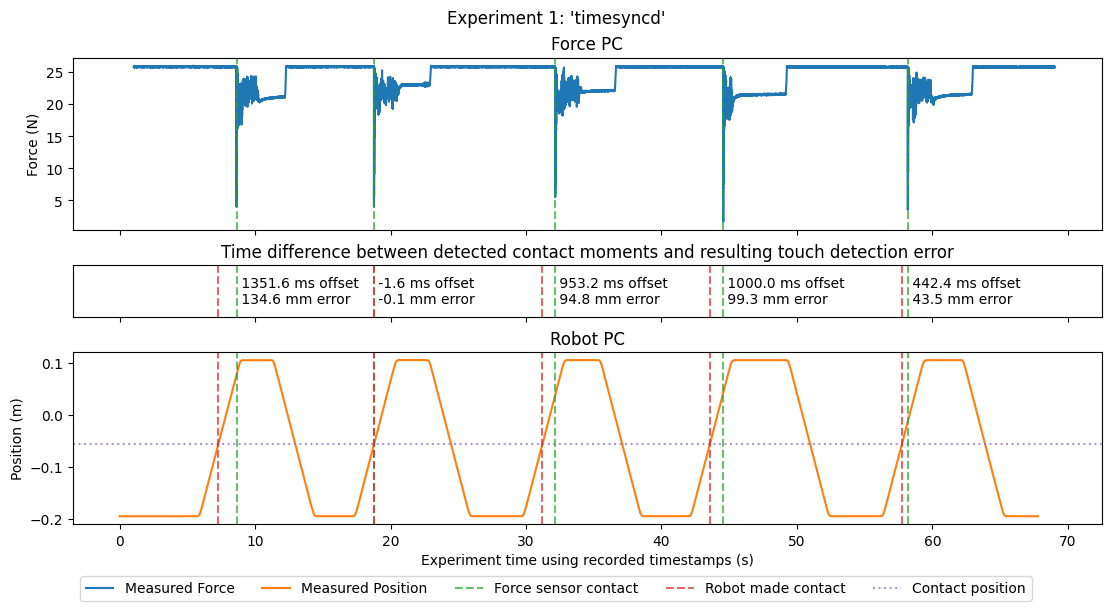

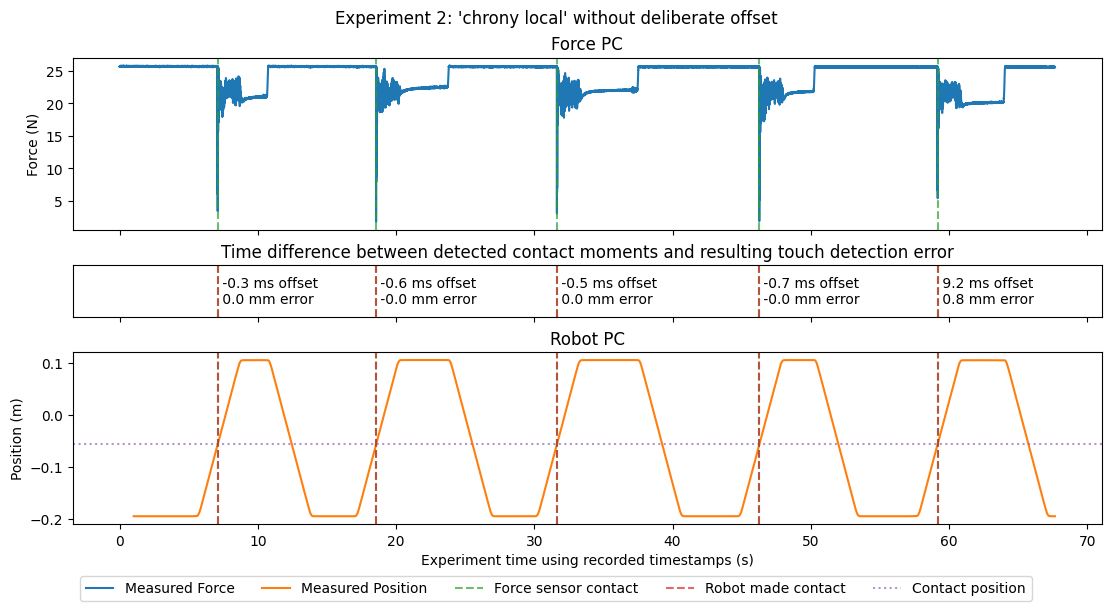

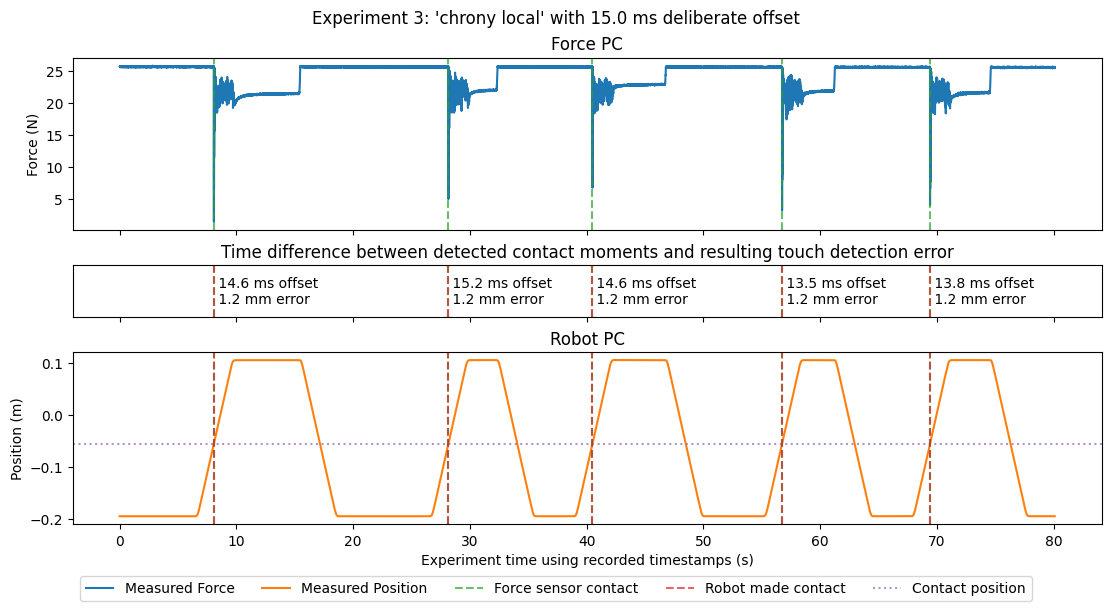

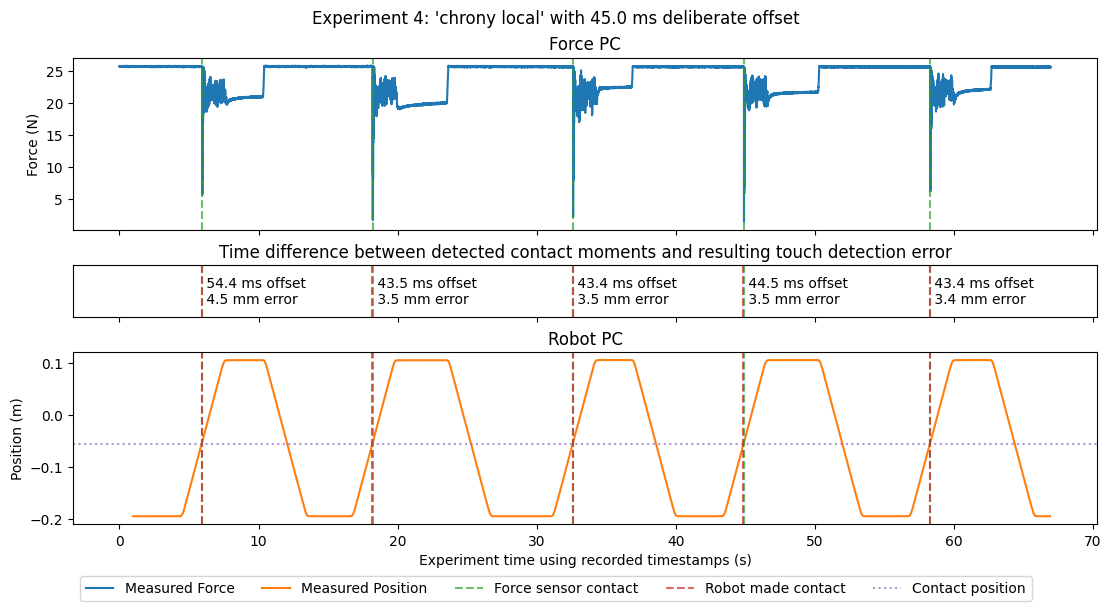

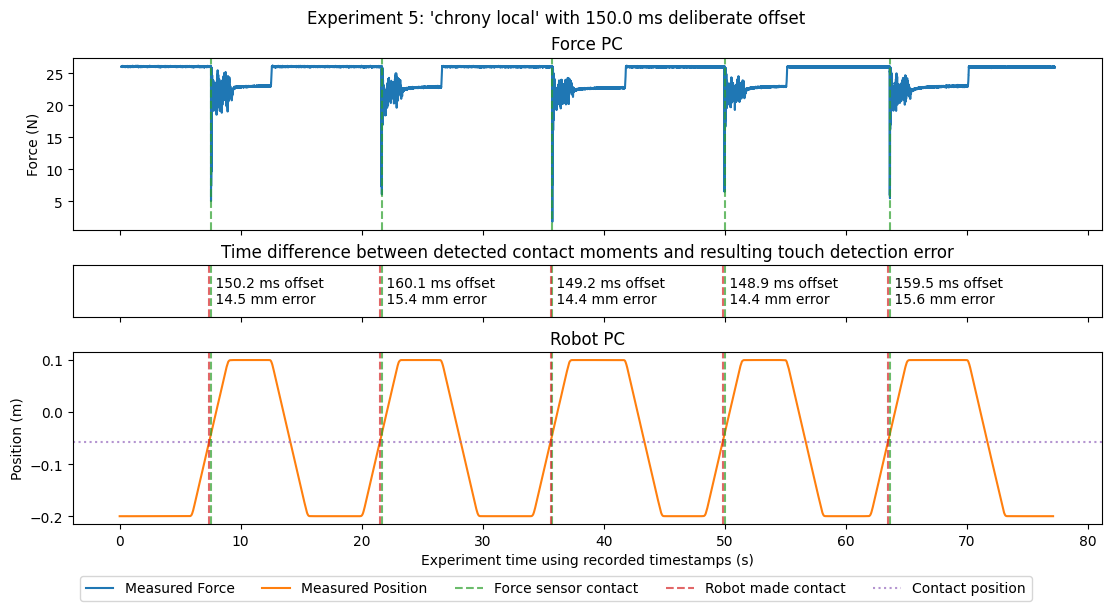

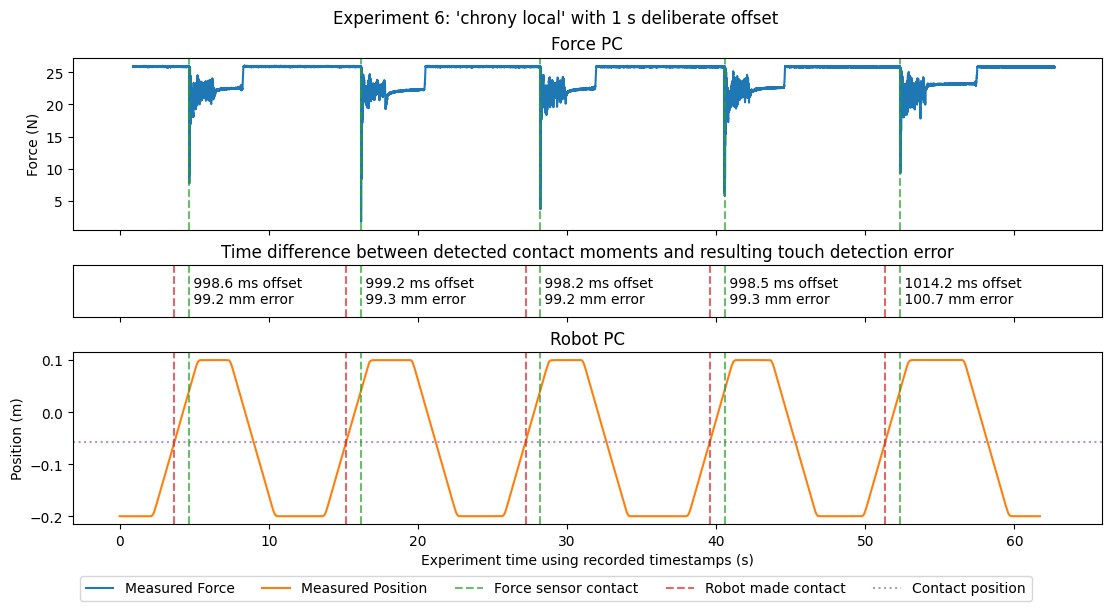

In [104]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy.signal import find_peaks

for _, experiment_row in overview_df.iterrows():
    # Prepare figure
    force_subplot: Axes
    contact_subplot: Axes
    robot_subplot: Axes
    fig, [force_subplot, contact_subplot, robot_subplot] = plt.subplots(
        nrows=3,
        ncols=1,
        sharex=True,
        figsize=(11, 6),
        height_ratios=(5, 1.5, 5),
        layout="constrained",
    )
    experiment_offset = experiment_row["offset"]
    if experiment_row["sync_type"] == ClockSyncType.TIMESYNCD.value:
        title = f"Experiment {experiment_row['exp_nr']}: '{experiment_row['sync_type']}'"
    elif experiment_offset == ZERO_OFFSET:
        title = f"Experiment {experiment_row['exp_nr']}: '{experiment_row['sync_type']}' without deliberate offset"
    else:
        title = f"Experiment {experiment_row['exp_nr']}: '{experiment_row['sync_type']}' with {short_timedelta_repr(experiment_offset)} deliberate offset"  # noqa: E501
    fig.suptitle(title)

    # Load data from CSV
    robot_df = pd.read_csv(experiment_row["robot_data_csv_path"])
    force_df = pd.read_csv(experiment_row["force_data_csv_path"])

    # Determine earliest timestamp to get relative time of experiments
    first_timestamp: float = min(robot_df["timestamp"].min(), force_df["timestamp"].min())
    robot_df["timestamp"] = robot_df["timestamp"] - first_timestamp
    force_df["timestamp"] = force_df["timestamp"] - first_timestamp

    # Find moments that the force sensor made contact
    force_df["dt"] = force_df["timestamp"] - force_df["timestamp"].shift()
    datapoints_between_peaks = 3 / force_df["dt"].mean()
    force_peaks, properties = find_peaks(-force_df["wrench_z"], distance=datapoints_between_peaks, prominence=10)
    force_df["made_contact"] = force_df.index.isin(force_peaks)
    force_made_contact_timestamps = force_df["timestamp"].iloc[force_peaks]
    # print(force_made_contact_timestamps)

    # Force subplot
    force_df.plot(
        x="timestamp",
        y=["wrench_z"],
        ax=force_subplot,
        color="C0",
        label=["Measured Force"],
        legend=False,
    )
    # force_subplot.plot(force_df["timestamp"].iloc[force_peaks], force_df["wrench_z"].iloc[force_peaks], "x")
    force_subplot.set_title("Force PC")
    force_subplot.set_ylabel("Force (N)")
    force_subplot.set_xlabel("Experiment time (s)")

    # For the robot data, determine when it moves past the contact point
    # I.e. point where robot is beyond contact now, but was before contact in previous state
    robot_df["made_contact"] = (robot_df["position_y"] > CONTACT_Y_COORDINATE) & (
        robot_df["position_y"].shift() < CONTACT_Y_COORDINATE
    )
    robot_made_contact_timestamps = robot_df.loc[robot_df["made_contact"], "timestamp"]
    # print(robot_made_contact_timestamps)

    # Robot subplot
    robot_df.plot(
        x="timestamp",
        y=[
            "position_y",
            # "velocity_y",
            # "acceleration_y",
        ],
        ax=robot_subplot,
        color="C1",
        label=["Measured Position"],
        legend=False,
    )
    robot_subplot.axhline(y=CONTACT_Y_COORDINATE, color="C4", linestyle=":", alpha=0.7, label="Contact position")
    robot_subplot.set_title("Robot PC")
    robot_subplot.set_ylabel("Position (m)")
    robot_subplot.set_xlabel("Experiment time using recorded timestamps (s)")

    # Show the moments that contact is made
    contact_time_difference = force_made_contact_timestamps.to_numpy() - robot_made_contact_timestamps.to_numpy()
    for i, ts in enumerate(force_made_contact_timestamps):
        force_subplot.axvline(x=ts, color="C2", linestyle="--", alpha=0.7)
        robot_subplot.axvline(x=ts, color="C2", linestyle="--", alpha=0.7)
        contact_subplot.axvline(x=ts, color="C2", linestyle="--", alpha=0.7, label="Force sensor contact")

        # Calculate the location of contact if the force data was used to determine that
        robot_index_closest_to_force_contact_ts = (robot_df["timestamp"] - ts).abs().idxmin()
        robot_df_row_at_force_contact_ts = robot_df.iloc[robot_index_closest_to_force_contact_ts]
        contact_location_based_on_force_sensor = robot_df_row_at_force_contact_ts["position_y"]
        contact_location_error_based_on_force_sensor = contact_location_based_on_force_sensor - CONTACT_Y_COORDINATE

        contact_subplot.text(
            ts,
            0.5,
            f" {contact_time_difference[i] * 1000:.01f} ms offset\n {contact_location_error_based_on_force_sensor * 1000:.01f} mm error",
            horizontalalignment="left",
            verticalalignment="center",
        )

    for ts in robot_made_contact_timestamps:
        robot_subplot.axvline(x=ts, color="C3", linestyle="--", alpha=0.7)
        contact_subplot.axvline(x=ts, color="C3", linestyle="--", alpha=0.7, label="Robot made contact")

    contact_subplot.set_title("Time difference between detected contact moments and resulting touch detection error")
    contact_subplot.set_yticks([])

    # Add legend outside the figure
    force_legend_handles, force_legend_labels = force_subplot.get_legend_handles_labels()
    contact_legend_handles, contact_legend_labels = contact_subplot.get_legend_handles_labels()
    robot_legend_handles, robot_legend_labels = robot_subplot.get_legend_handles_labels()
    legend_handles = force_legend_handles + contact_legend_handles + robot_legend_handles
    legend_labels = force_legend_labels + contact_legend_labels + robot_legend_labels

    unique_legend_entries = {}
    for handle, label in zip(legend_handles, legend_labels, strict=True):
        if label not in unique_legend_entries:
            unique_legend_entries[label] = handle
    sorted_legend_entries = sorted(unique_legend_entries.items(), key=lambda item: item[1].get_color())
    sorted_labels, sorted_handles = zip(*sorted_legend_entries, strict=True)

    fig.legend(
        handles=sorted_handles,
        labels=sorted_labels,
        loc="outside lower center",
        ncol=len(legend_handles),
    )

    # break  # TODO: Only plot the first one for now
